In [89]:
!pip install pyspark
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('rainbow')
sns.set_style('whitegrid')
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')

# pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.types import StructType
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, count, desc, max
from pyspark.ml.feature import  StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

CSV_FILE_1='Final_database.csv'
CSV_FILE_2= 'Database_to_calculate_popularity.csv'

pyspark requires Python '>=3.8' but the running Python is 3.7.3


In [90]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in c:\users\jaspreet singh\anaconda3\lib\site-packages (1.3.5)


In [91]:
pd.__version__

'1.3.5'

In [92]:
spark = SparkSession.builder.master("local[]").appName("Spotify-Song-Recommender").getOrCreate() #.enableHiveSupport()
spark

In [93]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
# sqlContext = SQLContext(spark)

C:\spark\spark\python\pyspark\sql\context.py:115: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [94]:
df = spark.read.option("header", True).csv(CSV_FILE_1)
df = df.withColumn('Release_date', F.to_date('Release_date', "yyyy-MM-dd"))
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'instrumentalness', 'tempo', 'duration_ms','time_signature', 'Days_since_release', 'n_words']

for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))
    
cols_to_drop = ['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing'] 
for c in cols_to_drop:
    df.drop(c).collect()
    
df.printSchema()

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: date (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acoustics: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveliness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nul

In [95]:
# Use os.path to join paths
CSV_FILE_2= 'Database_to_calculate_popularity.csv'

# Read the CSV file into a DataFrame
df_listenings = spark.read.format('csv').option('header', True).option('inferSchema', True).load(CSV_FILE_2)

# Show the DataFrame
df_listenings.show()

+---+-------+----------+--------+--------------------+--------------------+--------------------+--------------------+
|_c0|country|      date|position|                 uri|               track|               title|              artist|
+---+-------+----------+--------+--------------------+--------------------+--------------------+--------------------+
|  0| Global|05/11/2020|     1.0|https://open.spot...| Dakiti , Bad Bun...|             Dakiti | Bad Bunny, Jhay ...|
|  1| Global|05/11/2020|     2.0|https://open.spot...| positions , Aria...|          positions |      Ariana Grande |
|  2| Global|05/11/2020|     3.0|https://open.spot...|   Mood  , 24kGoldn |              Mood  |           24kGoldn |
|  3| Global|05/11/2020|     4.0|https://open.spot...| Lemonade  , Inte...|          Lemonade  |     Internet Money |
|  4| Global|05/11/2020|     5.0|https://open.spot...| Lonely  , Justin...|            Lonely  |      Justin Bieber |
|  5| Global|05/11/2020|     6.0|https://open.spot...| W

In [96]:
df_listenings = df_listenings.drop('date','country','uri') #drops date column
df_listenings = df_listenings.na.drop() # removes null values in the row
df_listenings.show()

+---+--------+--------------------+--------------------+--------------------+
|_c0|position|               track|               title|              artist|
+---+--------+--------------------+--------------------+--------------------+
|  0|     1.0| Dakiti , Bad Bun...|             Dakiti | Bad Bunny, Jhay ...|
|  1|     2.0| positions , Aria...|          positions |      Ariana Grande |
|  2|     3.0|   Mood  , 24kGoldn |              Mood  |           24kGoldn |
|  3|     4.0| Lemonade  , Inte...|          Lemonade  |     Internet Money |
|  4|     5.0| Lonely  , Justin...|            Lonely  |      Justin Bieber |
|  5|     6.0| What You Know Bo...| What You Know Bo...|          Pop Smoke |
|  6|     7.0|     Dynamite , BTS |           Dynamite |                BTS |
|  7|     8.0|     Hawái , Maluma |              Hawái |             Maluma |
|  8|     9.0| 34+35 , Ariana G...|              34+35 |      Ariana Grande |
|  9|    10.0|     WAP  , Cardi B |               WAP  |        

In [97]:
rows = df_listenings.count()
cols = len(df_listenings.columns)
print(rows,cols)

9791324 5


# EDA(Exploratory Data Analysis)
EDA is the procedure which is used to gather deep and hidden information about the dataset by categorizing the data in various different ways such as finding duplictes, finding and handling null values,and visulaization of data through plots, charts and graphs.
Here we are performing SQL queries, Plots and Figures, and using pyspark to filter results from the dataset.

In [98]:
# Getting Unique songs in the dataset

df.select(["Title","Artist"]).distinct().count()

56241

In [99]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))

Dataset Shape using spark syntax:
 (170633, 151)


In [100]:
# Top 200 most played songs on the spotify in past three years

result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )

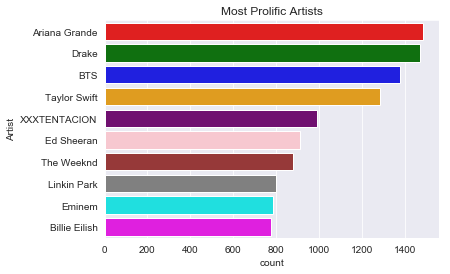

In [101]:
# Plotting the barplot of output songs
custom_colors = ["red", "green", "blue", "orange", "purple", "pink", "brown", "gray", "cyan", "magenta"]
sns.barplot(data=result_df, y='Artist', x='count', palette=custom_colors)
plt.title('Most Prolific Artists')
plt.show()

In [102]:
df.createOrReplaceTempView("df_table")

In [103]:
# Cross checking the dataset length
print("Now using the SQL Context. We can check it's the same length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

Now using the SQL Context. We can check it's the same length as before
+--------------+
|Dataset_Length|
+--------------+
|        170633|
+--------------+



In [104]:
# Finding the most popular artist by doing addition of their popular songs (USA)
query = """
SELECT
       Artist, 
       ROUND(SUM(Popularity), 2) AS Populartiy
FROM df_table
WHERE USA == 1
GROUP BY Artist
ORDER BY AVG(Popularity) DESC
LIMIT 10
"""

res = spark.sql(query)
res.show(10, truncate=False)

+------------------------------+----------+
|Artist                        |Populartiy|
+------------------------------+----------+
|Post Malone - Quavo           |130719.15 |
|XXXTENTACION - Trippie Redd   |97016.35  |
|Meek Mill - Drake             |83235.95  |
|Post Malone - 21 Savage       |159633.25 |
|Billie Eilish - Khalid        |79693.9   |
|Marshmello - Bastille         |74560.5   |
|Cardi B - Bad Bunny - J Balvin|74381.6   |
|Migos - Lil Uzi Vert          |70138.2   |
|BlocBoy JB - Drake            |69576.75  |
|Kendrick Lamar - Zacari       |67838.15  |
+------------------------------+----------+



In [105]:
# Showing the top 10 songs released in 1970
(df.filter(F.year(df['Release_date']) == 1970)
   .select('Title', 'Artist','Release_date', 'Genre')
   .distinct()
   .show(10, truncate=False)
)

+--------------------------------------------+---------------------------------+------------+---------------+
|Title                                       |Artist                           |Release_date|Genre          |
+--------------------------------------------+---------------------------------+------------+---------------+
|ill be home for christmas - single version  |Bing Crosby                      |1970-01-01  |adult standards|
|santa claus is coming to town               |The Jackson 5                    |1970-01-01  |motown         |
|mele kalikimaka - single version            |Bing Crosby - The Andrews Sisters|1970-01-01  |adult standards|
|god rest ye merry gentlemen - single version|Bing Crosby                      |1970-01-01  |adult standards|
|son of a preacher man                       |Aretha Franklin                  |1970-01-15  |classic soul   |
|i saw mommy kissing santa claus             |The Jackson 5                    |1970-01-01  |motown         |
|in the su

### Most Popular Song per Decade

In [106]:
# Getting the most popular song per decade
query = """
SELECT
    ROUND(Year(Release_date), -1) as Decade,
    ROUND(Max(Popularity), 2) as Popularity,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Title)), 12) AS Title,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Artist)), 12) AS Artist
FROM
    df_table
WHERE
    ROUND(Year(Release_date), -1) IS NOT NULL
    AND USA == 1
GROUP BY Decade
ORDER BY Decade ASC
"""

spark.sql(query).show()

+------+----------+--------------------+--------------------+
|Decade|Popularity|               Title|              Artist|
+------+----------+--------------------+--------------------+
|  1940|     840.5|     white christmas|Bing Crosby - Ken...|
|  1950|     997.6|ill be home for c...|         Bing Crosby|
|  1960|   9704.95|    jingle bell rock|         Bobby Helms|
|  1970|      98.4|what christmas me...|       Stevie Wonder|
|  1980|      98.6|dreams - 2004 rem...|       Fleetwood Mac|
|  1990|     97.75|            spoonman|         Soundgarden|
|  2000|   9476.05|       feliz navidad|      José Feliciano|
|  2010|     97.75|         tongue tied|           Grouplove|
|  2020|   99912.3|       drip too hard|    Lil Baby - Gunna|
+------+----------+--------------------+--------------------+



### Most popular Genre per decade

In [107]:
 # Most popular genres, period.
query = """
SELECT Genre, COUNT(*) AS Tally
FROM df_table
GROUP BY Genre
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

+---------+-----+
|    Genre|Tally|
+---------+-----+
|dance pop|25351|
|    latin| 7591|
|      pop| 7146|
|    k-pop| 4053|
|      n-a| 3952|
+---------+-----+
only showing top 5 rows



In [108]:
# Printing the genre and decade 
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre) AS counts
FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )

+------+-------------------+------+
|Decade|              Genre|counts|
+------+-------------------+------+
|  1900|vocal harmony group|     1|
|  1930|        movie tunes|     1|
|  1940|    adult standards|    39|
|  1950|    adult standards|    36|
|  1960|    adult standards|   186|
|  1970|       classic soul|   152|
|  1980|         album rock|   379|
|  1990|         irish rock|   170|
|  2000|  alternative metal|   477|
|  2010|          dance pop|  1052|
|  2020|          dance pop| 23496|
+------+-------------------+------+



## Most popular day for each track!
(checking for few data)

In [109]:
query = """
SELECT Title, Artist, Release_date, MAX(Popularity)
FROM df_table
WHERE Artist == "Paulo Londra"
GROUP BY Title, Artist, Release_date
LIMIT 10
"""

res = spark.sql(query).show()

+--------------------+------------+------------+------------------+
|               Title|      Artist|Release_date|   max(Popularity)|
+--------------------+------------+------------+------------------+
|          adan y eva|Paulo Londra|  2018-11-05| 849.6000000000001|
|          adan y eva|Paulo Londra|  2019-05-23| 57194.60000000001|
|    chica paranormal|Paulo Londra|  2018-07-24|           6341.35|
|    chica paranormal|Paulo Londra|  2019-05-23|           9409.05|
|condenado para el...|Paulo Londra|  2017-12-04| 617.6000000000001|
|condenado para el...|Paulo Londra|  2018-11-03|             852.0|
|condenado para el...|Paulo Londra|  2019-05-23| 586.7500000000001|
|confiado & tranquilo|Paulo Londra|  2017-05-30|375.20000000000016|
|        cámara lenta|Paulo Londra|  2017-10-07| 8088.800000000004|
|      demasiado loco|Paulo Londra|  2019-05-23| 6337.350000000001|
+--------------------+------------+------------+------------------+



## Changing of music patterns over the decade 

In [110]:
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )

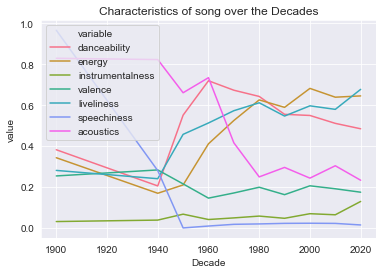

In [111]:
sns.lineplot(data=pd.melt(df_music_features, ['Decade']), x='Decade', y='value', hue='variable').set_title('Characteristics of song over the Decades');

# Clustering
Clustering is the task of dividing the unlabeled data or data points into different clusters such that similar data points fall in the same cluster than those which differ from the others. In simple words, the aim of the clustering process is to segregate groups with similar traits and assign them into clusters.

There are several techniques of comparing music similarities. One option is to simply use continuous, numerical variables (such as danceability, energy, and so on) and reduce dimensionality using PCA, k-means, or some other method and if we are only interested in the song features (continuous variables), we could simply generate a feature vector and use cosine similarity to discover the most similar sounding song while accounting for numerical attributes and one-hot-encoded countries. 

## Checking the cosine similarity of song feature vectors

In [112]:
# for pop
query_kpop = """
SELECT Title, Artist, {}
FROM df_table
WHERE `k-pop` = 1
""".format(', '.join(numerical_features))

df_kpop_songs = (spark.sql(query_kpop)
                      .sample(.1)
                      .dropna()
                      .toPandas()
                )
# for rap
query_rap = """
SELECT Title, Artist, {}
FROM df_table
WHERE rap = 1
""".format(', '.join(numerical_features))

df_rap_songs = (spark.sql(query_rap)
                     .sample(.1)
                     .dropna()
                     .toPandas()
               )
df_rap_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,revenge,XXXTENTACION,0.746,0.251,0.00203,0.180,0.106,0.259,0.782,0.00203,139.998993,120027.0,4.0,1177.0,475.0
1,revenge,XXXTENTACION,0.746,0.251,0.00203,0.180,0.106,0.259,0.782,0.00203,139.998993,120027.0,4.0,1177.0,475.0
2,nowadays,Lil Skies - Landon Cube,0.745,0.646,0.00000,0.460,0.338,0.170,0.157,0.00000,79.992996,203908.0,4.0,1068.0,130.0
3,nowadays,Lil Skies - Landon Cube,0.745,0.646,0.00000,0.460,0.338,0.170,0.157,0.00000,79.992996,203908.0,4.0,1068.0,130.0
4,party girl,StaySolidRocky - Lil Uzi Vert,0.752,0.375,0.00000,0.591,0.175,0.204,0.533,0.00000,129.994995,147673.0,4.0,120.0,342.0


In [113]:
df_kpop_songs.head()

,Title,Artist,danceability,energy,instrumentalness,valence,liveliness,speechiness,acoustics,instrumentalness,tempo,duration_ms,time_signature,Days_since_release,n_words
0,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.66,0.787,0.0,0.199,0.323,0.032,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0
1,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.66,0.787,0.0,0.199,0.323,0.032,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0
2,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.66,0.787,0.0,0.199,0.323,0.032,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0
3,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.66,0.787,0.0,0.199,0.323,0.032,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0
4,more,K/DA - Madison Beer - (G)I-DLE - Lexie Liu - J...,0.66,0.787,0.0,0.199,0.323,0.032,0.00257,0.0,142.018005,217088.0,4.0,17.0,1344.0


In [114]:
from scipy import spatial
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
transformer = Normalizer()

# drop the title and artist with the iloc
scaled_kpop_df = scaler.fit_transform(df_kpop_songs.iloc[:, 2:]) 
scaled_rap_df = scaler.fit_transform(df_rap_songs.iloc[:, 2:])


# printing the cosine similarity of a rap and a k-pop song
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_kpop_df[2])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of a rap and a k-pop song:", result)

Cosine similarity of a rap and a k-pop song: 0.7047742015385319


C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [115]:
# Printing the cosine similarity of two rap songs
song1 = np.array(scaled_rap_df[1])
song2 = np.array(scaled_rap_df[10])
result = 1 - spatial.distance.cosine(song1, song2)
print("Cosine similarity of two rap songs:", result)

Cosine similarity of two rap songs: 0.6782908770743485


## Dimensionality Reduction
Dimensionality reduction refers to techniques for reducing the number of input variables in training data.This is useful for visualizing kmeans clustering later.In this case, we're going to take two types of music (Kpop and Rap), and then try reducing all the numeric, musical features down to two dimentions. The two dimentions won't really represent the genre of the music, but we can pretend that this is true. When we do KMeans clustering later on, we can visualize it on these two PCA axis.

In [116]:
df_rap_songs = df_rap_songs.assign(is_rap=1,
                                   is_kpop=0
                                   )
df_kpop_songs = df_kpop_songs.assign(is_rap=0,
                                     is_kpop=1
                                     )
df_rap_and_kpop = pd.concat([df_rap_songs, df_kpop_songs])
X = scaler.fit_transform(df_rap_and_kpop.iloc[:, 2:])

pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.46299297 0.12215436 0.09036743 0.07413849 0.05731787 0.04588504
 0.03694465 0.02938006 0.02641448 0.02075377]


C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype int64, float32 were all converted to float64 by MinMaxScaler.



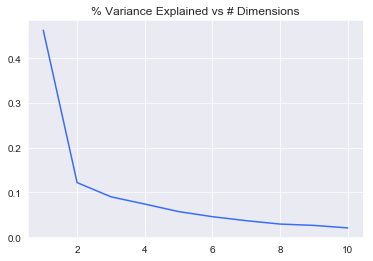

In [117]:
sns.lineplot(x=[x for x in range(1, 11)], y=pca.explained_variance_ratio_).set_title("% Variance Explained vs # Dimensions");

As expected, it's able to explain most the vairance using 1 dimension. This roughly corresponds to "genre," which instead was encoded as either `is_rap` or `is_kpop`

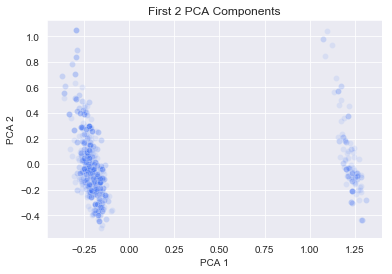

In [118]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principalComponents)

# sns.scatterplot(data=principalComponents, alpha=.1)
sns.scatterplot(x=PCA_components[0], y=PCA_components[1], alpha=.1).set_title("First 2 PCA Components");
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

The first component is particularly excellent at separation

## Kmeans Clustering
K-means clustering is a method for grouping n observations into K clusters

Finding the best number of clusters with an elbow plot. Viewed the top 2 PCA clusters, and then used kmeans with various number of clusters. The "Scree" plot below, shows the percent of variance explained as a function of the number of clusters used

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:444: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/r

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:

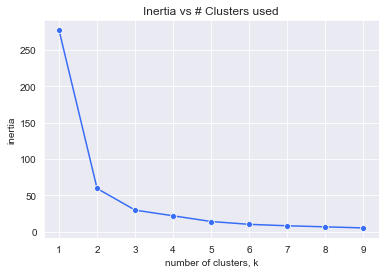

In [119]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Creating a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fitting model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Appending the inertia to the list of inertias
    inertias.append(model.inertia_)
    
sns.lineplot(x=ks, y=inertias, marker='o').set_title("Inertia vs # Clusters used")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Again, as expected, 2 clusters seems to make sense

In [120]:
km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:444: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/r

In [121]:
df_pca_kmeans_plot = pd.concat([PCA_components, pd.Series(y_km)], axis=1)
df_pca_kmeans_plot.columns = ['PCA_1', 'PCA_2', 'Cluster']

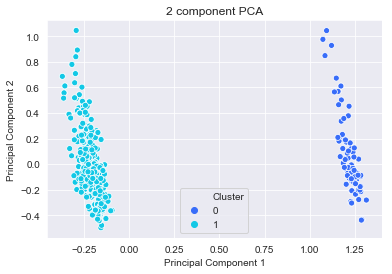

In [122]:
sns.scatterplot(data=df_pca_kmeans_plot, x='PCA_1', y='PCA_2', hue='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

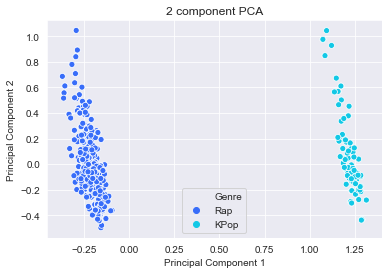

In [123]:
#Coloring the genre instead of cluster
df_final = pd.concat([df_pca_kmeans_plot, df_rap_and_kpop.reset_index()['is_rap']], axis=1)
df_final['is_rap'] = df_final['is_rap'].replace({1:'Rap', 0: 'KPop'})
df_final['Cluster'] = df_final['Cluster'].replace({1:'Cluster 2', 0: 'Cluster 1'})
df_final = df_final.rename(columns={'is_rap': 'Genre'})

sns.scatterplot(data=df_final, x='PCA_1', y='PCA_2', hue='Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

[0.23076758 0.16296684 0.13656165 0.11934573 0.08340215 0.06797699
 0.05294164 0.04760344 0.03766495 0.02748947]


C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



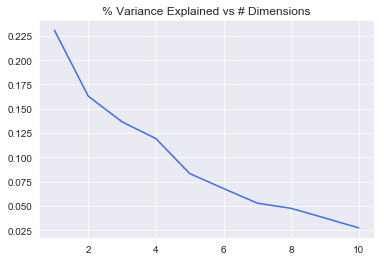

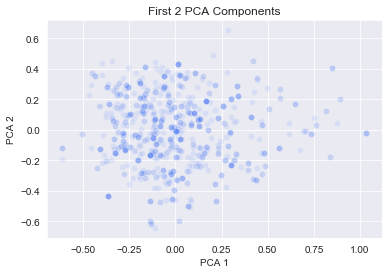

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:

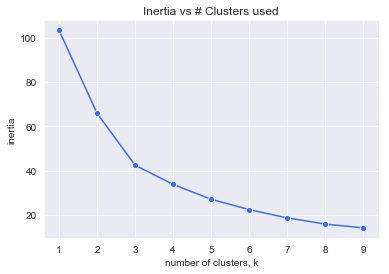

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:444: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/r

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:54: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:444: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/r

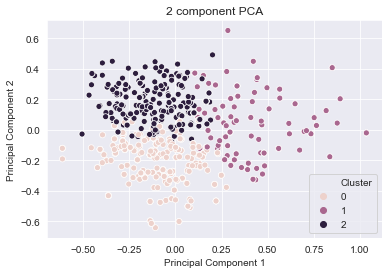

In [124]:
df_rap_and_kpop = pd.concat([df_rap_songs, df_kpop_songs])
rap_kpop_labels = df_rap_and_kpop[['is_rap', 'is_kpop']]
df_rap_and_kpop = df_rap_and_kpop.drop(columns=['is_rap', 'is_kpop'])
X = scaler.fit_transform(df_rap_and_kpop.iloc[:, 2:])

pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
sns.lineplot(x=[x for x in range(1, 11)], y=pca.explained_variance_ratio_).set_title("% Variance Explained vs # Dimensions")
plt.show()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principalComponents)

# Doing scatterplot where data is equal to principalComponents and alpha=0.1
sns.scatterplot(x=PCA_components[0], y=PCA_components[1], alpha=.1).set_title("First 2 PCA Components");
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');
plt.show()


ks = range(1, 10)
inertias = []
for k in ks:
    # Creating a KMeans instance with k clusters model
    model = KMeans(n_clusters=k)
    
    # Fitting model to samples
    model.fit(PCA_components.iloc[:,:2])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
sns.lineplot(x=ks, y=inertias, marker='o').set_title("Inertia vs # Clusters used")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

df_pca_kmeans_plot = pd.concat([PCA_components, pd.Series(y_km)], axis=1)
df_pca_kmeans_plot.columns = ['PCA_1', 'PCA_2', 'Cluster']
sns.scatterplot(data=df_pca_kmeans_plot, x='PCA_1', y='PCA_2', hue='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

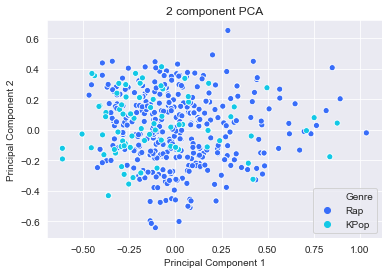

In [125]:
df_final = pd.concat([df_pca_kmeans_plot, rap_kpop_labels.reset_index()['is_rap']], axis=1)
df_final['is_rap'] = df_final['is_rap'].replace({1:'Rap', 0: 'KPop'})
df_final['Cluster'] = df_final['Cluster'].replace({1:'Cluster 2', 0: 'Cluster 1'})
df_final = df_final.rename(columns={'is_rap': 'Genre'})
sns.scatterplot(data=df_final, x='PCA_1', y='PCA_2', hue='Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA');

In [126]:
df_listenings_agg = df_listenings.select('position', 'track').groupby('position', 'track').agg(count('*').alias('count')).orderBy('position')
df_listenings_agg.show()

+--------+--------------------+-----+
|position|               track|count|
+--------+--------------------+-----+
|     1.0| Better Now , Pos...|  148|
|     1.0| Going Bad  , Mee...|    2|
|     1.0| Falling Down - B...|   50|
|     1.0| Angel Eyes , Sadri |    3|
|     1.0| HUMBLE. , Kendri...|  141|
|     1.0|   079 , Lo & Leduc |   86|
|     1.0| Sour Candy  , La...|   17|
|     1.0| Dagdrøm  , Hans ...|    3|
|     1.0| Call Out My Name...|   47|
|     1.0| Planer , Gilli, ...|    4|
|     1.0| Mi Gente , J Bal...|  643|
|     1.0| Kuningaskobra  ,...|    6|
|     1.0| Standard  , Kits...|   38|
|     1.0| Vedän sut henkee...|    2|
|     1.0| Lemonade  , Inte...|   25|
|     1.0| Hukutaan , Arttu...|    3|
|     1.0| Lose You To Love...|   16|
|     1.0| Pilasit mun eläm...|    4|
|     1.0| Good,es  , Post ...|    7|
|     1.0|  Traîtres , Lacrim |    1|
+--------+--------------------+-----+
only showing top 20 rows



In [127]:
row = df_listenings_agg.count()
col = len(df_listenings_agg.columns)
print(row,col)

2013989 3


In [128]:
df_listenings_agg = df_listenings_agg.limit(50000)

In [129]:
old_strindexer = [StringIndexer(inputCol = col, outputCol = col + '_index').fit(df_listenings_agg) for col in list(set(df_listenings_agg.columns)- set(['count']))]
indexer = [curr_strindexer.setHandleInvalid("keep") for curr_strindexer in old_strindexer]
stages = [(f"indexer_{i}", curr_indexer) for i, curr_indexer in enumerate(indexer)]
pipeline = Pipeline(stages = indexer)
data = pipeline.fit(df_listenings_agg).transform(df_listenings_agg)
data.show()

+--------+--------------------+-----+-----------+--------------+
|position|               track|count|track_index|position_index|
+--------+--------------------+-----+-----------+--------------+
|     1.0|       Roman , Edis |   13|     1458.0|          14.0|
|     1.0| Yok Yok , Feride...|    4|      709.0|          14.0|
|     1.0| One Kiss  , Calv...|  259|      532.0|          14.0|
|     1.0| New Rules , Dua ...|  172|      514.0|          14.0|
|     1.0| Look What You Ma...|  186|      471.0|          14.0|
|     1.0| The Box , Roddy ...|  257|      176.0|          14.0|
|     1.0| Pain 1993  , Drake |    2|     1430.0|          14.0|
|     1.0| thank u, next , ...|  548|      727.0|          14.0|
|     1.0| Woman Like Me  ,...|    4|      207.0|          14.0|
|     1.0| Freaky Friday  ,...|   46|      373.0|          14.0|
|     1.0| MIDDLE CHILD , J...|   16|      478.0|          14.0|
|     1.0| positions , Aria...|   89|      724.0|          14.0|
|     1.0| Too Good At Go

In [130]:
data = data.select('position_index', 'track_index', 'count').orderBy('position_index')
data.show()

+--------------+-----------+-----+
|position_index|track_index|count|
+--------------+-----------+-----+
|           0.0|     4497.0|    1|
|           0.0|     2326.0|    1|
|           0.0|      793.0|   67|
|           0.0|      664.0|   27|
|           0.0|     5553.0|    7|
|           0.0|     6827.0|    8|
|           0.0|      143.0|   59|
|           0.0|     4790.0|    9|
|           0.0|     6081.0|    2|
|           0.0|     4687.0|    1|
|           0.0|     2698.0|    5|
|           0.0|     3906.0|   16|
|           0.0|      627.0|   62|
|           0.0|      388.0|   42|
|           0.0|     2852.0|    7|
|           0.0|     1166.0|   13|
|           0.0|     4150.0|    1|
|           0.0|      113.0|  110|
|           0.0|     6724.0|    1|
|           0.0|     3021.0|    4|
+--------------+-----------+-----+
only showing top 20 rows



In [131]:
# Splitting the data
(training, test) = data.randomSplit([0.5,0.5])

In [132]:
POSITION = "position_index"
TRACK = "track_index"
COUNT = "count"

als = ALS(maxIter = 5, regParam = 0.01, userCol = POSITION, itemCol = TRACK, ratingCol = COUNT)
# Alternating Least Squares algorithm
model = als.fit(training)
predictions = model.transform(test)

In [133]:
recs = model.recommendForAllUsers(10)
recs.show()

+--------------+--------------------+
|position_index|     recommendations|
+--------------+--------------------+
|            10|[{326, 593.027}, ...|
|             0|[{726, 356.63486}...|
|             1|[{726, 425.97897}...|
|            11|[{286, 738.5516},...|
|            12|[{608, 1246.4878}...|
|             2|[{726, 461.57938}...|
|            13|[{726, 320.89792}...|
|             3|[{619, 288.15347}...|
|             4|[{326, 601.71936}...|
|            14|[{331, 1676.6317}...|
|             5|[{286, 553.1337},...|
|             6|[{331, 741.0326},...|
|             7|[{326, 467.93015}...|
|             8|[{286, 433.53763}...|
|             9|[{726, 712.5075},...|
+--------------+--------------------+



In [134]:
# Showing the 10 recommendations for 2 user
recs.take(2)

[Row(position_index=10, recommendations=[Row(track_index=326, rating=593.0269775390625), Row(track_index=286, rating=586.2105712890625), Row(track_index=608, rating=435.0699157714844), Row(track_index=154, rating=344.1035461425781), Row(track_index=396, rating=342.7657470703125), Row(track_index=620, rating=316.9205322265625), Row(track_index=744, rating=303.6836853027344), Row(track_index=97, rating=282.4179992675781), Row(track_index=340, rating=256.03009033203125), Row(track_index=492, rating=253.91285705566406)]),
 Row(position_index=0, recommendations=[Row(track_index=726, rating=356.6348571777344), Row(track_index=340, rating=341.7913513183594), Row(track_index=619, rating=323.70428466796875), Row(track_index=286, rating=285.90087890625), Row(track_index=326, rating=260.04583740234375), Row(track_index=608, rating=246.96315002441406), Row(track_index=1086, rating=199.37522888183594), Row(track_index=514, rating=196.89488220214844), Row(track_index=25, rating=181.1317138671875), R

# Finding the most similar song

In [135]:
query_all = """
SELECT Title, Artist, Genre, {}
FROM df_table
""".format(', '.join(numerical_features))

df_all_songs = (spark.sql(query_all)
                     .dropna()
                     .toPandas()
                     .drop_duplicates(['Title', 'Artist'])
                     .reset_index(drop=True)
                )

In [136]:
df_all_songs.columns

Index(['Title', 'Artist', 'Genre', 'danceability', 'energy',
       'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
       'instrumentalness', 'tempo', 'duration_ms', 'time_signature',
       'Days_since_release', 'n_words'],
      dtype='object')

In [137]:
df_all_songs_ohe = pd.get_dummies(df_all_songs.drop(columns='Title'))
scaled_df_all_songs_ohe = scaler.fit_transform(df_all_songs_ohe)

C:\Users\Jaspreet Singh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype uint8, float32 were all converted to float64 by MinMaxScaler.



In [138]:
def get_most_similar_song(title, artist):
    title = title.lower()
    
    # getting the vector for the requested song
    song_idx = df_all_songs.query(f"Title == '{title}' and Artist == '{artist}'").index.values[0]
    song_vector = scaled_df_all_songs_ohe[song_idx]
    
    # finding the most similar song
    min_difference = 1
    closest_song_idx = 0
    for index, song in enumerate(scaled_df_all_songs_ohe):
        distance = spatial.distance.cosine(song_vector, song)
        if distance < min_difference:
            if index == song_idx:
                pass
            else:
                min_difference = distance
                closest_song_idx = index
    
    # getting the title and the artist of the most similar song
    closest_song = df_all_songs.loc[closest_song_idx,['Title', 'Artist']]
    print("Closest Song:\n-------------", closest_song, sep="\n")
    return closest_song_idx

In [139]:
get_most_similar_song("Numb", "Linkin Park")

Closest Song:
-------------
Title        crawling
Artist    Linkin Park
Name: 1470, dtype: object


1470

In [140]:
spark.sql("SELECT Artist, Title FROM df_table WHERE Artist LIKE 'Radio%'").distinct().show(50)

+---------+------------------+
|   Artist|             Title|
+---------+------------------+
|Radiohead|             creep|
|Radiohead|        man of war|
|Radiohead|      karma police|
|Radiohead|      high and dry|
|Radiohead|      no surprises|
|Radiohead|  paranoid android|
|Radiohead|fake plastic trees|
|Radiohead|          ill wind|
+---------+------------------+



### Showing some recommendations based on the user input

In [141]:
get_most_similar_song("it wont kill ya", "The Chainsmokers - Louane")

Closest Song:
-------------
Title                         bad blood
Artist    Taylor Swift - Kendrick Lamar
Name: 7629, dtype: object


7629

In [142]:
get_most_similar_song("how would you feel", "Ed Sheeran")

Closest Song:
-------------
Title        happier
Artist    Ed Sheeran
Name: 1756, dtype: object


1756

In [143]:
get_most_similar_song("the box", "Roddy Ricch")

Closest Song:
-------------
Title           intro
Artist    Roddy Ricch
Name: 3700, dtype: object


3700